<a href="https://colab.research.google.com/github/Zahra-ziaee/Fraud-Transaction-Detection/blob/main/Fraud_Transaction_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1069%2F1940%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240617%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240617T110451Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6c0b7730d664971bf773004c78b75013138cca931bc15b8653db9c9ee408b995ac6f77476b9e9528e8df1ea85f6e0db234850cac417ef192dcaac7dbb28a2f4eb5fe59ccfdb938d2d22e6ca9d04da3315a26c58e4014bb93d13e80bc6d4838b6daddad04ac1ed9b5a732b698ada14b9658d13b378f6a931423c14fa28b3fdab8b0f564b428e2decede5c259739d3c496d0502d0f7be800ead80f396a2c36585488673af760a18de33fb56fd9af4cf53e5a6822be764fcc697fbcaf4589e25a2c0ab539093aefdef82485c2cc27e6c74b1c67fac765e534c54b6453cddc075a167f9741929e068cf2cfc882d59b6556f2f215fb81c8c7a8156dc36f137ea1c585'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 186385561 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [2]:
import pandas as pd
import numpy as np

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')

In [6]:
print('Data does not have any NULL value.')
data.isnull().any()

Data does not have any NULL value.


step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

In [7]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
data.rename(columns={'newbalanceOrig':'newbalanceOrg'},inplace=True)
data.drop(labels=['nameOrig','nameDest'],axis=1,inplace=True)

The provided data has the financial transaction data as well as the target variable **isFraud**, which is the actual fraud status of the transaction and **isFlaggedFraud** is the indicator which the simulation is used to flag the transaction using some **threshold value**.

In [9]:
print('Minimum value of Amount, Old/New Balance of Origin/Destination:')
data[[ 'amount','oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']].min()

Minimum value of Amount, Old/New Balance of Origin/Destination:


amount            0.0
oldbalanceOrg     0.0
newbalanceOrg     0.0
oldbalanceDest    0.0
newbalanceDest    0.0
dtype: float64

In [10]:
print('Maximum value of Amount, Old/New Balance of Origin/Destination:')
data[[ 'amount','oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']].max()

Maximum value of Amount, Old/New Balance of Origin/Destination:


amount            9.244552e+07
oldbalanceOrg     5.958504e+07
newbalanceOrg     4.958504e+07
oldbalanceDest    3.560159e+08
newbalanceDest    3.561793e+08
dtype: float64

## Data Analysis

----
Since there is **no missing** and **garbage value**, there is no need for data cleaning, but we still need to perform **data analysis** as data contaion huge variation of the value in different columns. Normalization will also imporve the overall accuracy of the machine learning model.

----

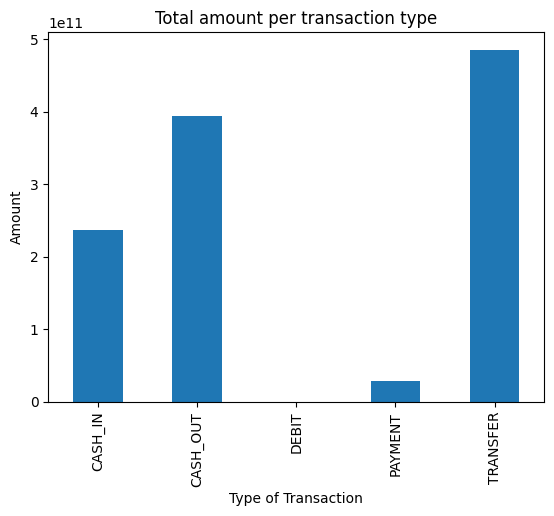

In [11]:
var = data.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
var.plot(kind='bar')
ax1.set_title("Total amount per transaction type")
ax1.set_xlabel('Type of Transaction')
ax1.set_ylabel('Amount');

In [12]:
data.loc[data.isFraud == 1].type.unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrg   float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
 8   isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 436.9+ MB


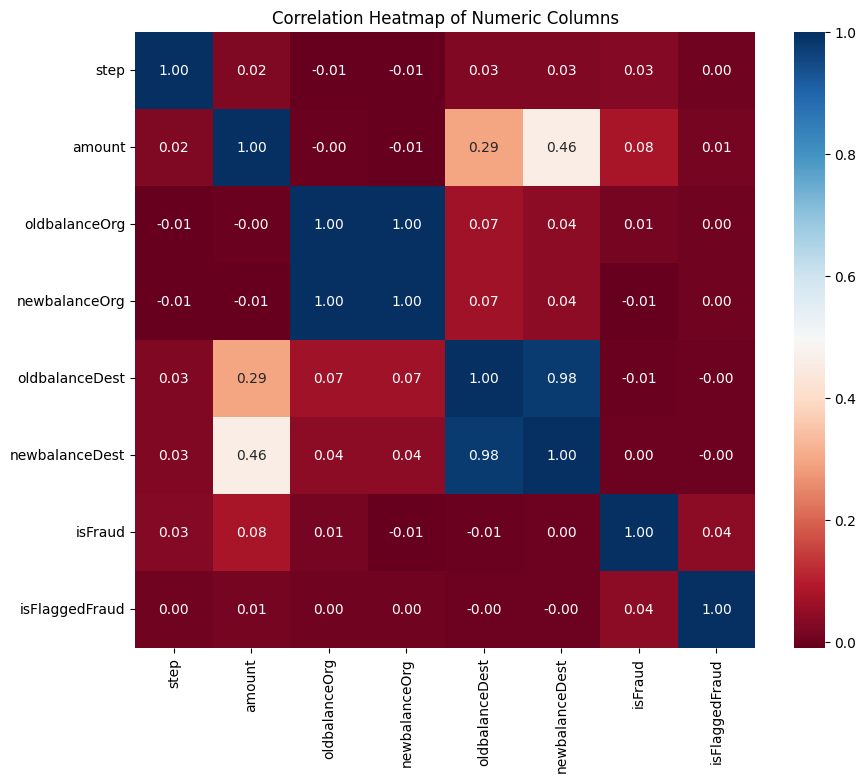

In [14]:


# Assuming 'data' is your DataFrame
# Select numeric columns only
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='RdBu', annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

** Things we can conclude from this heatmap: **
*   Amount is correlated with isFraud(Target Variable).
*   OldbalanceOrg and NewbalanceOrg are highly correlated.   
*   OldbalanceDest and NewbalanceDest are highly correlated.

There is not much relation between the features, so we need to understand where the relationship between them depends on the type of transaction and amount. To do so, we need to see the heat map of fraud and nonfraud transactions differently.

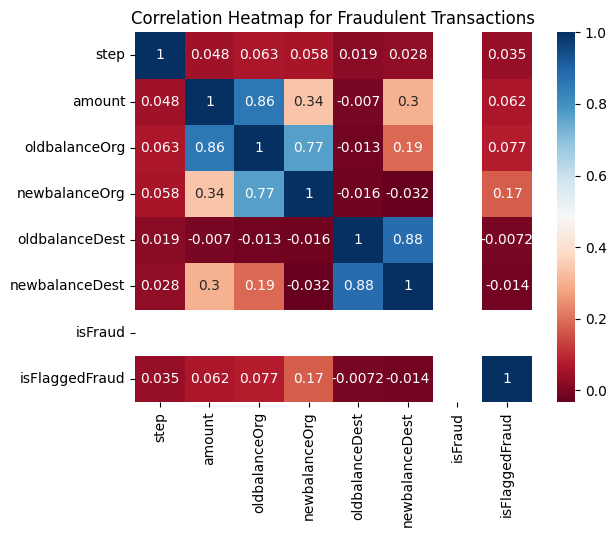

In [19]:
# Assuming 'isFraud' is a categorical variable, convert it to numeric if needed
fraud = data[data['isFraud'] == 1]
nonfraud = data[data['isFraud'] == 0]

# Selecting numeric columns for correlation calculation
numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
numeric_data = fraud[numeric_cols]

# Computing correlation matrix
corr_matrix = numeric_data.corr()

# Plotting heatmap
sns.heatmap(corr_matrix, cmap='RdBu', annot=True)
plt.title('Correlation Heatmap for Fraudulent Transactions')
plt.show()

There are 2 flags which stand out to me and it's interesting to look onto: isFraud and isFlaggedFraud column. From the hypothesis, isFraud is the indicator which indicates the actual fraud transactions whereas isFlaggedFraud is what the system prevents the transaction due to some thresholds being triggered. From the above heatmap we can see that there is some relation between other columns and isFlaggedFraud thus there must be relation between isFraud.



In [20]:
print('The total number of fraud transaction is {}.'.format(data.isFraud.sum()))
print('The total number of fraud transaction which is marked as fraud {}.'.format(data.isFlaggedFraud.sum()))
print('Ratio of fraud transaction vs non-fraud transaction is 1:{}.'.format(int(nonfraudcount//fraudcount)))

The total number of fraud transaction is 8213.
The total number of fraud transaction which is marked as fraud 16.
Ratio of fraud transaction vs non-fraud transaction is 1:773.


In [21]:
print('Thus in every 773 transaction there is 1 fraud transaction happening.')
print('Amount lost due to these fraud transaction is ${}.'.format(int(fraud.amount.sum())))

Thus in every 773 transaction there is 1 fraud transaction happening.
Amount lost due to these fraud transaction is $12056415427.


In [22]:
piedata = fraud.groupby(['isFlaggedFraud']).sum()

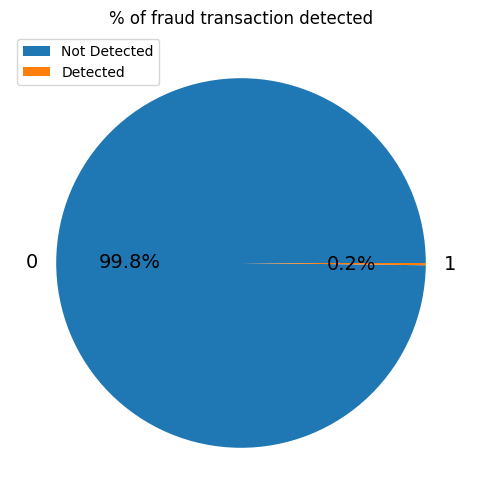

In [23]:
f, axes = plt.subplots(1,1, figsize=(6,6))
axes.set_title("% of fraud transaction detected")
piedata.plot(kind='pie',y='isFraud',ax=axes, fontsize=14,shadow=False,autopct='%1.1f%%');
axes.set_ylabel('');
plt.legend(loc='upper left',labels=['Not Detected','Detected'])
plt.show()

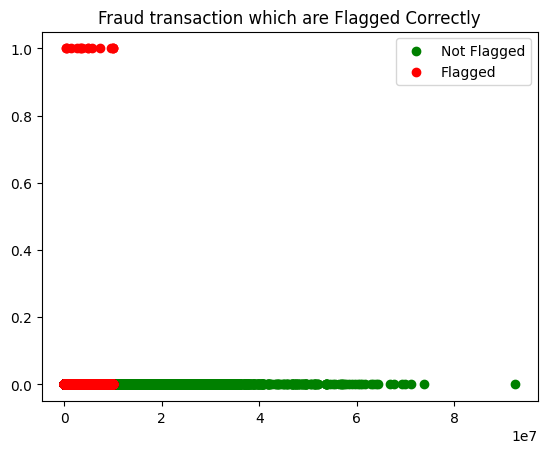

In [24]:
fig = plt.figure()
axes = fig.add_subplot(1,1,1)
axes.set_title("Fraud transaction which are Flagged Correctly")
axes.scatter(nonfraud['amount'],nonfraud['isFlaggedFraud'],c='g')
axes.scatter(fraud['amount'],fraud['isFlaggedFraud'],c='r')
plt.legend(loc='upper right',labels=['Not Flagged','Flagged'])
plt.show()

The plot above clearly shows the **need** for a system which can be **fast** and **reliable** to mark the transaction which is fraud. Since, the current system is letting fraud transaction able to **pass through a system** which is **not labeling them as a fraud**. Some data exploration can be helpful to check for the relation between features.

## Data Exploration


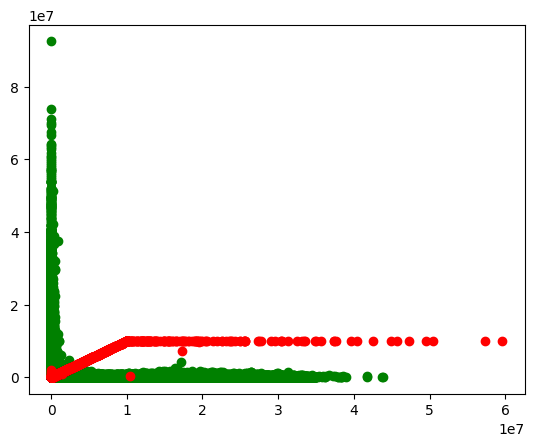

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(nonfraud['oldbalanceOrg'],nonfraud['amount'],c='g')
ax.scatter(fraud['oldbalanceOrg'],fraud['amount'],c='r')
plt.show()

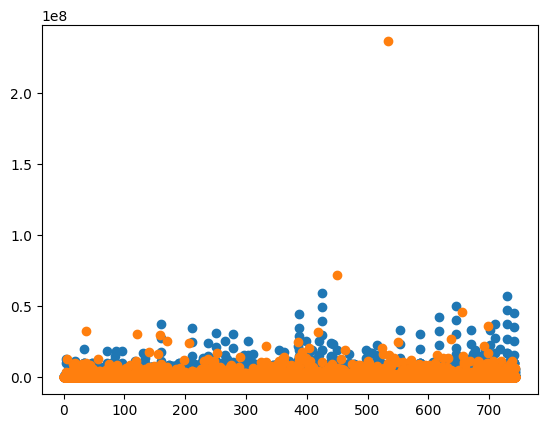

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(fraud['step'],fraud['oldbalanceOrg'])
ax.scatter(fraud['step'],fraud['oldbalanceDest'])
plt.show()

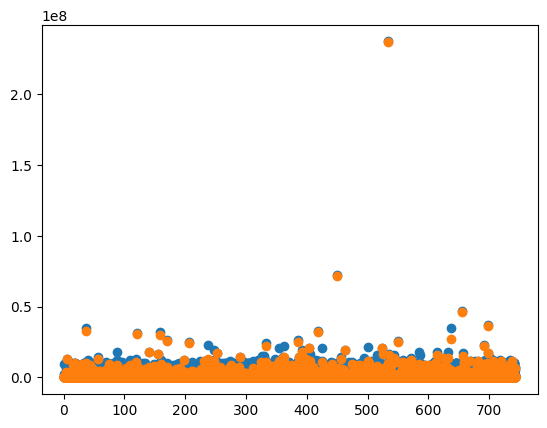

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(fraud['step'],fraud['newbalanceDest'])
ax.scatter(fraud['step'],fraud['oldbalanceDest'])
plt.show()

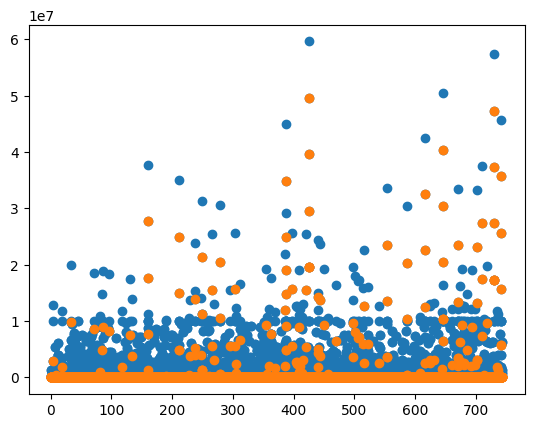

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(fraud['step'],fraud['oldbalanceOrg'])
ax.scatter(fraud['step'],fraud['newbalanceOrg'])
plt.show()

##Data Cleaning

In [29]:
import pandas as pd
import numpy as np
import pickle

In [30]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [31]:
data_fraud = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')

In [32]:
data_fraud = data_fraud.replace(to_replace={'PAYMENT':1,'TRANSFER':2,'CASH_OUT':3,
                                            'CASH_IN':4,'DEBIT':5,'No':0,'Yes':1})

In [33]:
data_fraud.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)

In [34]:
data_fraud.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,1,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,1,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,2,181.00,181.0,0.00,0.0,0.0,1
3,1,3,181.00,181.0,0.00,21182.0,0.0,1
4,1,1,11668.14,41554.0,29885.86,0.0,0.0,0


In [35]:
X = data_fraud.drop(['isFraud'],axis=1)
y = data_fraud[['isFraud']]

## Machine Learning Model

In [36]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 121)

In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=15)

In [38]:
if True:
    probabilities = clf.fit(train_X, train_y.values.ravel()).predict(test_X)

In [39]:
from sklearn.metrics import average_precision_score
if True:
    print(average_precision_score(test_y,probabilities))

0.769265382241955



**Average precision score is 0.7692**

# Conclusion
*  Existing rule-based system is **not capable** of detection of all the fraud transaction.
*  **Machine learning** can be used for the detection of fraud transaction.
*  Predictive models produce **good** precision score and are capable of detection of fraud transaction.